This Notebook has been created by PALISSON Antoine

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

### Datasets

In [2]:
from sklearn.datasets import fetch_openml

# Fasion dataset
fashion_mnist = fetch_openml("Fashion-MNIST", version=1, parser='auto')
fashion_mnist = pd.concat([fashion_mnist['data'], fashion_mnist['target']], axis=1)
fashion_mnist['class'] = fashion_mnist['class'].map({"0" : "T-shirt/top",
                                                     "1" : "Trouser",
                                                     "2" : "Pullover",
                                                     "3" : "Dress",
                                                     "4" : "Coat",
                                                     "5" : "Sandal",
                                                     "6" : "Shirt",
                                                     "7" : "Sneaker",
                                                     "8" : "Bag",
                                                     "9" : "Ankle boot"})

# Snapchat dataset
snapchat_review = fetch_openml("Snapchat-Google-PlayStore-Reviews", version=1, parser='auto')['data']
snapchat_review = snapchat_review.drop(['Date', 'Helpful'], axis=1)
snapchat_review = snapchat_review.drop(snapchat_review[snapchat_review['Rating'] == 3].index, axis=0).reset_index(drop=True)
snapchat_review['Rating'] = snapchat_review['Rating'].transform(lambda x: "Positive" if x >= 4 else "Negative")

# Fashion classification

**Fashion MNIST** is a popular benchmark dataset for image classification in the field of machine learning. It consists of a set of 70,000 grayscale images of size 28x28 pixels, representing 10 different categories of clothing and accessories, such as t-shirts, trousers, dresses, and shoes.

Fashion MNIST is widely used in research and education as a replacement for the traditional MNIST dataset of handwritten digits, which has become too easy for modern machine learning algorithms to classify accurately. Fashion MNIST presents a more challenging task for image classification, while still being relatively small and easy to work with.

Fashion MNIST was created by a team of researchers from Zalando, and it has been used as a benchmark dataset for evaluating the performance of various machine learning models, including deep neural networks. The dataset can be downloaded from the official Fashion MNIST website, along with code examples for working with the data in various programming languages.

**<font color='blue'>1.a. Show the fashion mnist first rows.**

In [ ]:
fashion_mnist.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Ankle boot
1,0,0,0,0,0,1,0,0,0,0,...,114,130,76,0,0,0,0,0,0,T-shirt/top
2,0,0,0,0,0,0,0,0,0,22,...,0,1,0,0,0,0,0,0,0,T-shirt/top
3,0,0,0,0,0,0,0,0,33,96,...,0,0,0,0,0,0,0,0,0,Dress
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,T-shirt/top


To show an image stored in a DataFrame in Python:


1.   **Reshape the data**: Reshaping the data involves changing the dimensions of an array without changing the underlying data. To reshape the data, you can use the **`reshape()`** function in NumPy. For example, if the original image dimensions are 28x28 pixels, we can reshape a one-dimensional array image_data of length 784 into a two-dimensional array image_array of shape (28, 28). [Documentation](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html).
```
arr_reshaped = np.reshape(arr, (28,28))
```


2.   **Display the image**: To display the data, you can use the **`imshow()`** function in NumPy. You can play with the image color using the `cmap` parameter that can be a string representing a named colormap (such as 'gray', 'binary' or 'viridis'). [Documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html).
```
import matplotlib.pyplot as plt
plt.imshow(arr_reshaped, ...)
```

**<font color='blue'>1.b. Display some of the images of the dataset.**

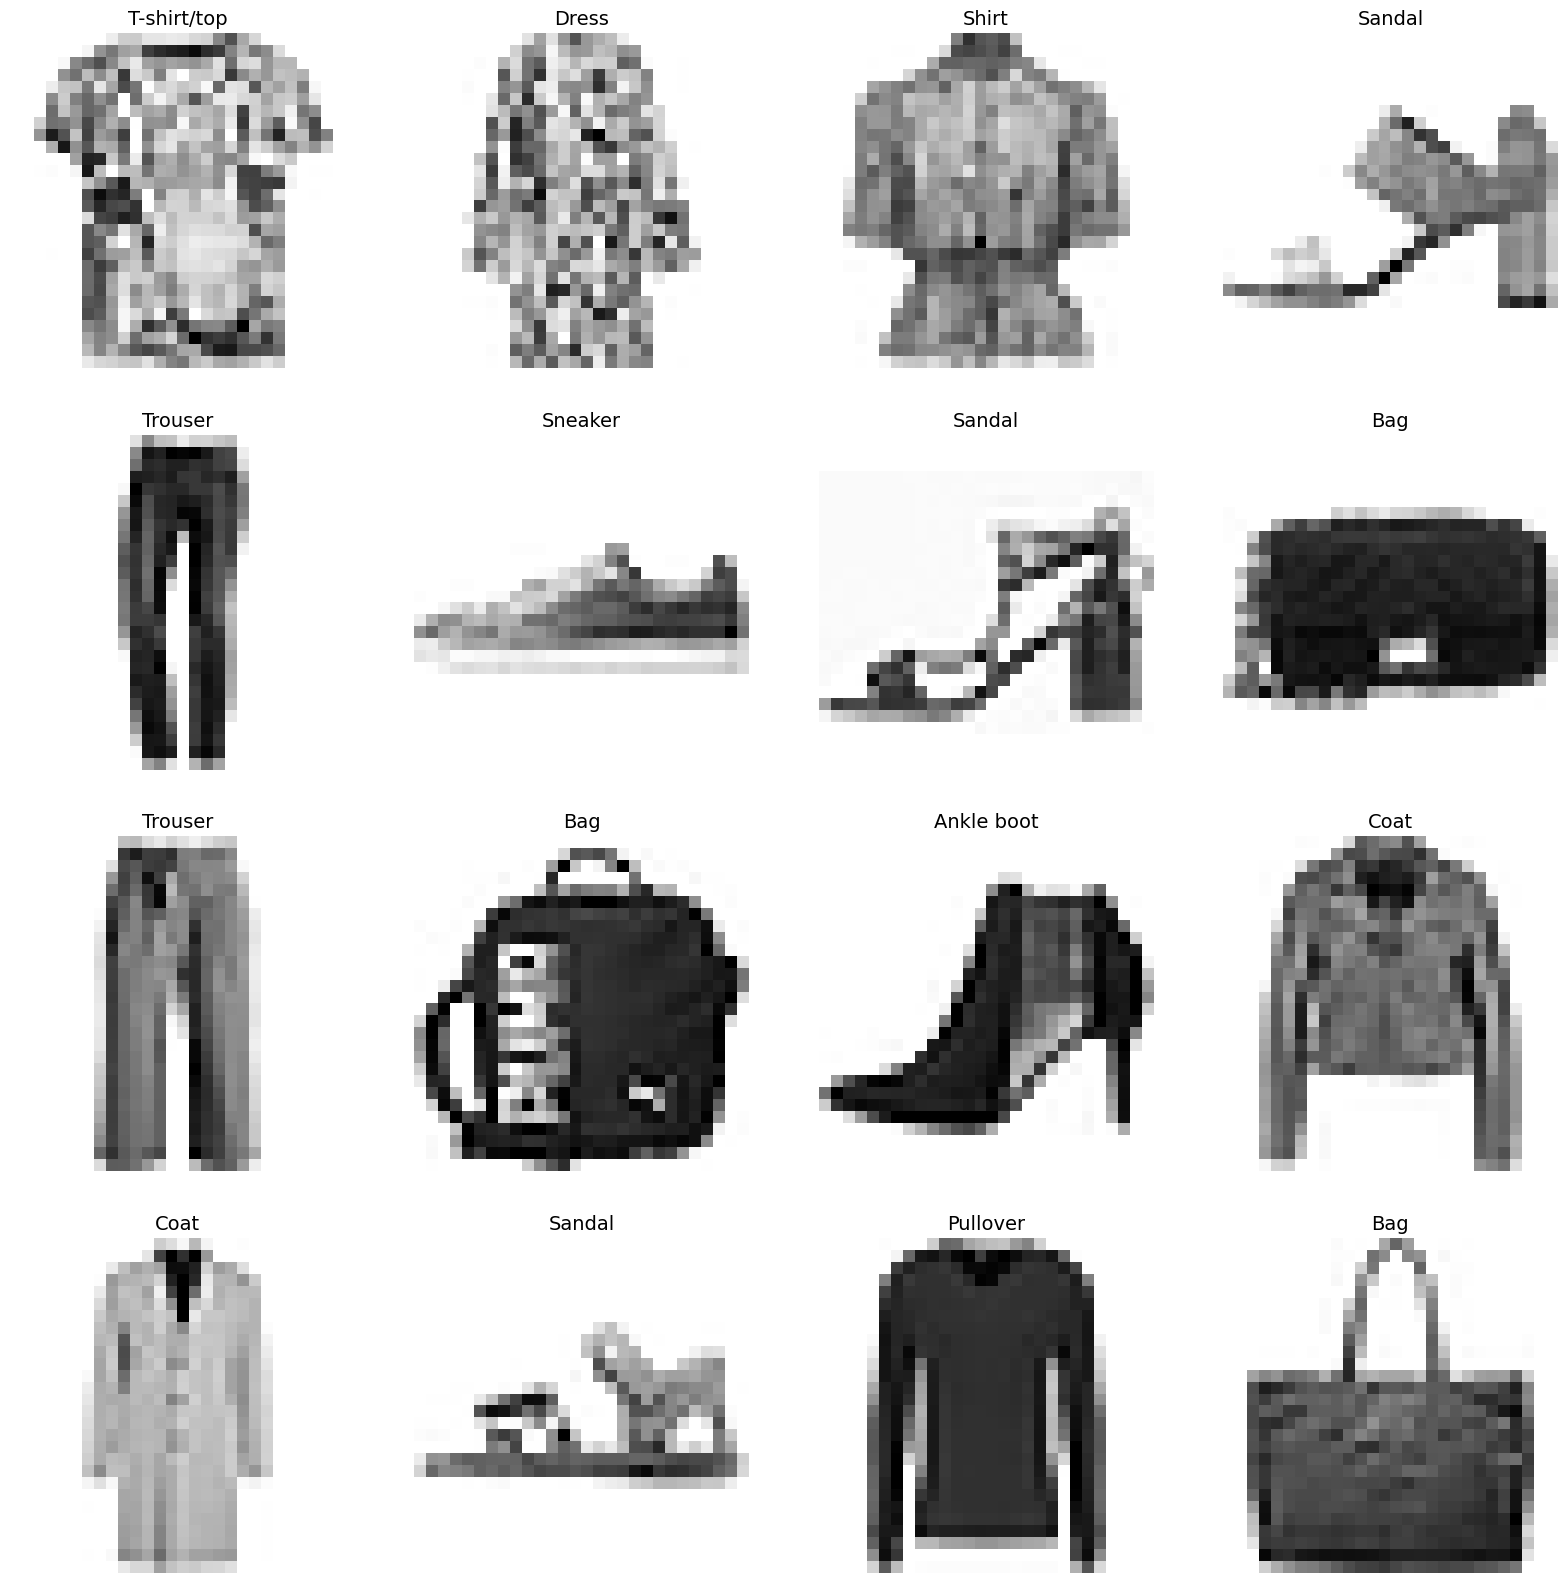

In [ ]:
fig, axs = plt.subplots(4,4, figsize=(20,20))

sample = fashion_mnist.sample(n=16)
imgs = sample.iloc[:,:-1].to_numpy().astype(np.int64)
labels = sample.iloc[:,-1].to_numpy()

for img, label, ax in zip(imgs, labels, axs.flatten()):
    ax.imshow(img.reshape(28,28), cmap='binary')
    ax.set_title(label, fontsize=14)
    ax.axis('off')

plt.show()

**<font color='blue'>2.a. Separate the features from the labels.**

In [ ]:
X = fashion_mnist.copy()
y = X.pop('class')

**<font color='blue'>2.b. Create a training, a validation and a testing set.**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    stratify=y,
                                                    test_size=0.3,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,
                                                  stratify=y_train,
                                                  test_size=0.1/(1-0.3),
                                                  random_state=42)

An image is generally composed of **pixels** which are integers that range from 0 to 255.

Pixels are generally **normalized to a common scale**, such as between 0 and 1, to ensure that the values are comparable and have similar ranges. This can be done by dividing the pixel values by the maximum pixel value (e.g. 255 for 8-bit grayscale images).

**<font color='blue'>3.a. Preprocess the features by dividing the features by 255.**

In [ ]:
X_train /= 255
X_val /= 255
X_test /= 255

**<font color='blue'>3.b. Encode the labels into numbers.**

In [ ]:
from sklearn.preprocessing import LabelEncoder
lbl_enc = LabelEncoder()
y_train = lbl_enc.fit_transform(y_train)
y_val = lbl_enc.transform(y_val)
y_test = lbl_enc.transform(y_test)

Convolutional Neural Networks (CNNs) need images of shape ***(instances, height,width, channel)***.

The (instances, width, height, channel) format represents a four-dimensional array, where:

* **instances**: The number of images in the dataset.
* **width**: The width of each image in pixels.
* **height**: The height of each image in pixels.
* **channel**: The number of color channels in each image (1 for grayscale images, 3 for RGB color images).

For example, if you have a DataFrame with 28x28 grayscale images (i.e., one color channel), you can reshape the data into a (..., 28, 28, 1) array using the following code:

```
# -1 in the first dimension means that the number of instances is inferred automatically
arr_reshaped = np.reshape(arr, (-1, 28, 28, 1))
```



**<font color='blue'>3.c. Reshape the training, validation and testing sets into a (instances, height,width, channel) format.**

In [ ]:
X_train = X_train.to_numpy().reshape(-1,28,28,1)
X_val = X_val.to_numpy().reshape(-1,28,28,1)
X_test = X_test.to_numpy().reshape(-1,28,28,1)

**Convolutional layers** are a fundamental building block in convolutional neural networks (CNNs). They apply a set of filters (also known as kernels) to an input image to extract features and create a set of output feature maps. The process of applying these filters is called convolution.

![img](https://stanford.edu/~shervine/teaching/cs-230/illustrations/architecture-cnn-en.jpeg?3b7fccd728e29dc619e1bd8022bf71cf)

Here's a brief overview of the key concepts in convolutional layers:

* **Filter**: A small matrix of weights that is applied to a small region of the input image. The filter is slid across the entire input image and applied to each small region to generate a feature map.
* **Feature map**: A 2D array of values that represents the response of each filter to the input image. Each filter produces one feature map.
 
 <center><img width=70% height=auto src=https://stanford.edu/~shervine/teaching/cs-230/illustrations/convolution-layer-a.png?1c517e00cb8d709baf32fc3d39ebae67/>

* **Stride**: The number of pixels that the filter moves horizontally or vertically on each slide across the input image.
* **Padding**: A technique used to ensure that the output feature map has the same size as the input image. Padding adds zeros around the edges of the input image before applying the filter.

---

**`tf.keras.layers.Conv2D`** is a class in TensorFlow's high-level API Keras that represents a 2D convolutional layer for use in convolutional neural networks (CNNs). The reason why convolutional layers in CNNs typically use 2D filters is because images and videos are 2D spatial structures. Here's an overview of the main parameters:

* **`filters`**: The number of filters (or output channels) in the convolution. This parameter determines the depth of the output tensor, which can be different from the depth of the input tensor if filters is not equal to the input's number of channels. This parameter is required.
* **`kernel_size`**: The height and width of the convolutional kernel (or filter) as an integer or a tuple of two integers. For example, (3, 3) means a 3x3 kernel.
* **`strides`**: The stride of the convolution as a tuple of two integers, which specifies the step size of the kernel along the height and width dimensions. Default is (1, 1) which means the kernel slides one pixel at a time.
* **`padding`**: One of "valid" or "same". "valid" means no padding is applied and the output size will be reduced. "same" means zero-padding is applied to the input so that the output size is the same as the input size.
* **`activation`**: The activation function to apply to the output of the convolution. Common choices include ReLU, sigmoid, and tanh.

```
conv = tf.keras.layers.Conv2D(filters=...,
                              kernel_size=...,
                              strides=...,
                              padding=...,
                              activation=...)
```

Conv2D [Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)

---

Convolutional layers are often associated with **max pooling** and **flatten layers** in CNNs.

* **Max pooling**: Max pooling is a downsampling technique that reduces the spatial dimensions of the feature maps while preserving the most important information. It does this by taking the maximum value in a local neighborhood of the feature map. Max pooling helps to reduce the computational complexity of the network by reducing the number of parameters in the model, and it also helps to prevent overfitting by introducing some degree of translation invariance. You can use the **`MaxPooling2D`** from [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D).

* **Flatten layer**: A flatten layer is used to convert the 2D feature maps produced by the convolutional and pooling layers into a 1D vector that can be fed into a fully connected layer. This is necessary because fully connected layers can only accept inputs as a 1D vector. The flatten layer essentially "flattens" the feature maps into a vector by stacking the rows of the 2D feature map on top of each other. You can use the **`Flatten`** from [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten).

```
max_pooling = tf.keras.layers.MaxPooling2D(pool_size=...,
                                           strides=...,
                                           padding=...)
flatten = tf.keras.layers.Flatten()
```

**<font color='blue'>4.a. Create a model using:**

*   **<font color='blue'>One convolutional layer with 32 filters, a kernel size of 3x3 and a relu activation function**
*   **Followed by one max pooling layer with a pool size of 2x2**
*   **Followed by one flattening layer**
*   **Followed by one dense layer with 32 neurons and a relu activation function**
*   **Followed by a final dense layer for a classification task.**

In [ ]:
tf.keras.backend.clear_session()

input_ = tf.keras.Input(shape=(28,28,1))

conv1 = tf.keras.layers.Conv2D(filters = 32, 
                               kernel_size = (3, 3), 
                               activation = 'relu')(input_)

maxpool1 = tf.keras.layers.MaxPooling2D(2)(conv1)

flat = tf.keras.layers.Flatten()(maxpool1)

dense1 = tf.keras.layers.Dense(units=32, 
                               activation='relu')(flat)

output_ = tf.keras.layers.Dense(10, activation='softmax')(dense1)

In [ ]:
model = tf.keras.Model(inputs=input_, outputs=output_)

**<font color='blue'>4.b. Display the architecture of the model using `summary()`or `keras.utils.plot_model()`.**

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 32)                173088    
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                             

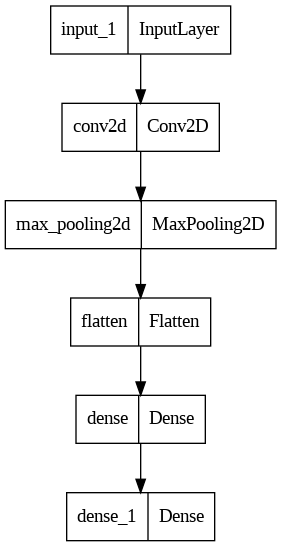

In [ ]:
tf.keras.utils.plot_model(model)

**<font color='blue'>5. Compile the model using the correct loss, the Adam optimizer with a learning rate of 0.001 and the accuracy metric.**

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

**<font color='blue'>6. Train the model for 10 epochs with a batch size of 64.**

*Tips: Don't forget to use the validation data and to save the output of the fit function.*

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/10
657/657 [==============================] - 4s 4ms/step - loss: 0.5019 - accuracy: 0.8241 - val_loss: 0.3505 - val_accuracy: 0.8744
Epoch 2/10
657/657 [==============================] - 2s 4ms/step - loss: 0.3255 - accuracy: 0.8852 - val_loss: 0.3064 - val_accuracy: 0.8927
Epoch 3/10
657/657 [==============================] - 2s 4ms/step - loss: 0.2814 - accuracy: 0.8999 - val_loss: 0.2832 - val_accuracy: 0.8970
Epoch 4/10
657/657 [==============================] - 2s 3ms/step - loss: 0.2535 - accuracy: 0.9081 - val_loss: 0.2710 - val_accuracy: 0.9022
Epoch 5/10
657/657 [==============================] - 2s 3ms/step - loss: 0.2335 - accuracy: 0.9153 - val_loss: 0.2773 - val_accuracy: 0.8987
Epoch 6/10
657/657 [==============================] - 2s 3ms/step - loss: 0.2162 - accuracy: 0.9211 - val_loss: 0.2724 - val_accuracy: 0.8997
Epoch 7/10
657/657 [==============================] - 2s 3ms/step - loss: 0.1972 - accuracy: 0.9285 - val_loss: 0.2838 - val_accuracy: 0.8997
Epoch 

**<font color='blue'>7.a. Display the learning curves.**

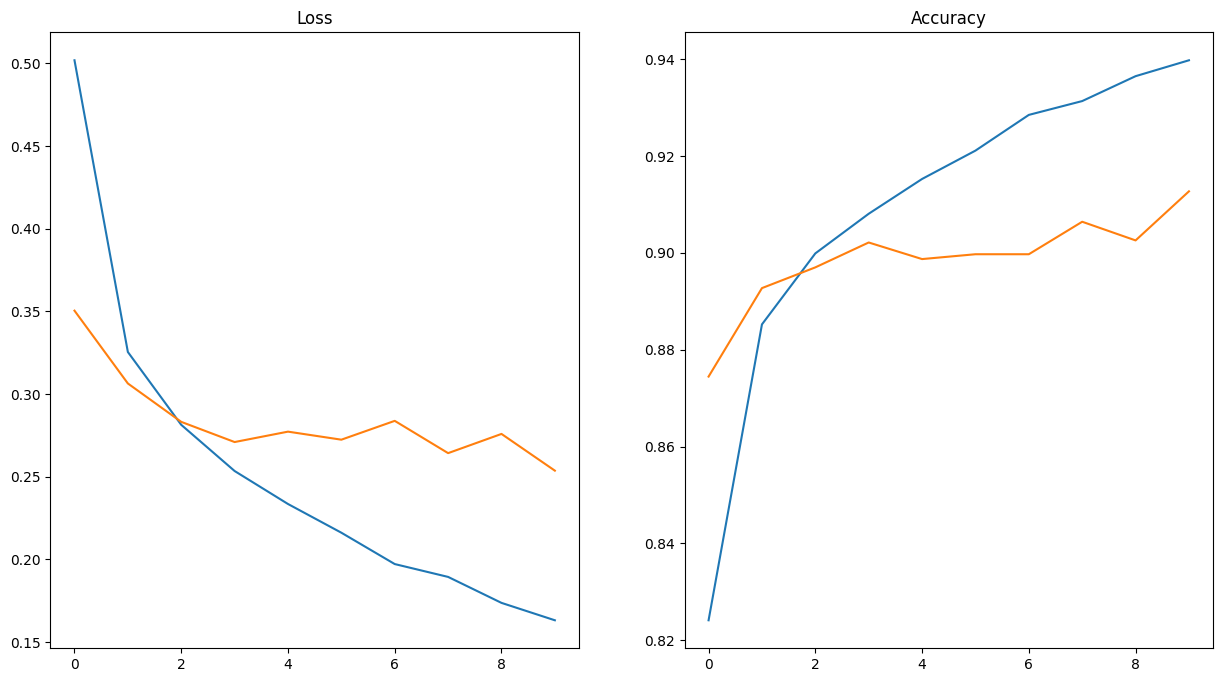

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,8))

axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='val loss')
axs[0].set_title('Loss')
axs[1].plot(history.history['accuracy'], label='accuracy')
axs[1].plot(history.history['val_accuracy'], label='val accuracy')
axs[1].set_title('Accuracy')

plt.show()

**<font color='blue'>7.b. Evaluate the model on the test set and display the confusion matrix.**

In [ ]:
model.evaluate(X_test, y_test)

657/657 [==============================] - 1s 2ms/step - loss: 0.2647 - accuracy: 0.9113


[0.2646927535533905, 0.9113333225250244]

In [ ]:
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred, axis=-1)

657/657 [==============================] - 1s 1ms/step


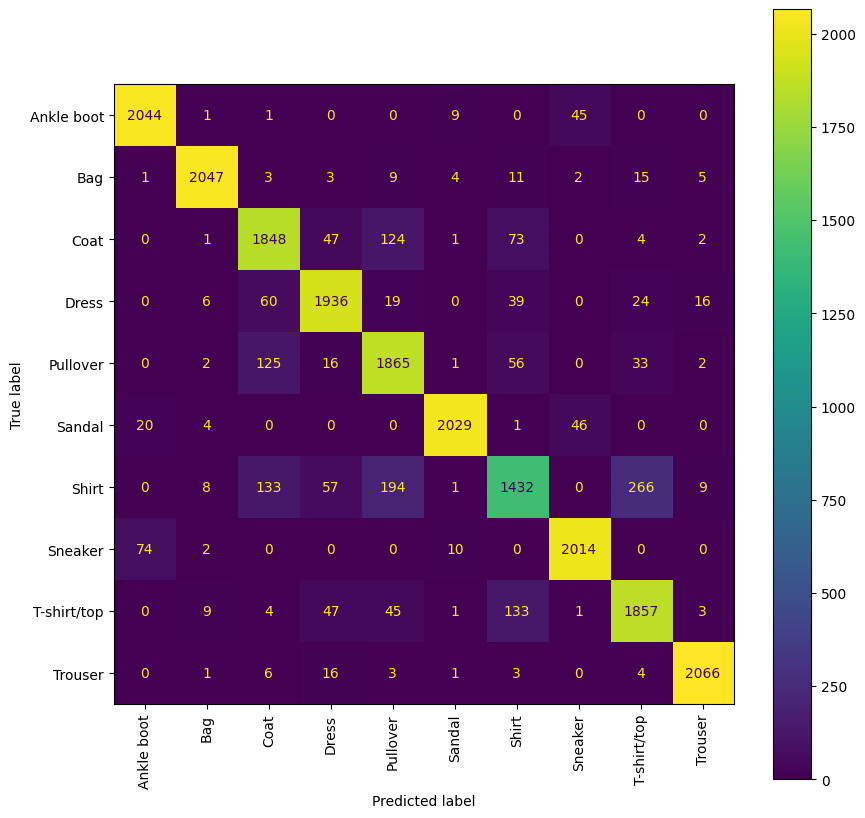

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        ax=ax,
                                        display_labels=lbl_enc.classes_,
                                        xticks_rotation='vertical')
plt.show()

**<font color='blue'>8.a. Choose and display an image from the dataset.**

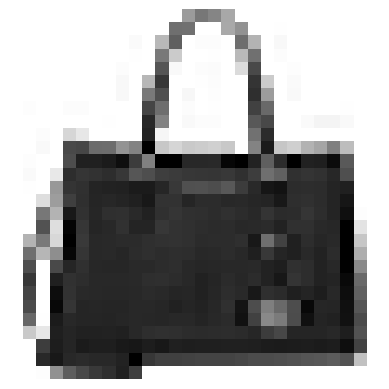

In [ ]:
img = X_train[1].reshape(28,28)
plt.imshow(img, cmap='binary')
plt.axis('off')
plt.show()


Tensorflow model's layers can be accessed using the `.layers` attribute.<br> It returns a list of all the layers of the model.

```
layers = model.layers
```


**<font color='blue'>8.b. Extract the convolutional layer from the model and pass the image as an input.**

*Tips: Remember to reshape the image to a (instances, height, width, channel) shape.*

In [ ]:
activations = model.layers[1](img.reshape(1,28,28,1))

Assuming an **input of shape (batch_size, height, width, channels)** and a convolutional layer with filters number of filters, kernel_size size of filters, stride stride, and 'same' padding, the **output tensor will have a shape of (batch_size, height, width, filters)**.

If the inputs have the same size (height and width) and the same number of instance per batch (batch_size) then the individual filters can be accessed by indexing the filters dimension:

```
for i in range(n):
   output[:,:,:,i] # filter map n°i
```

**<font color='blue'>8.c. Display the 32 feature maps using the `imshow()` function.**

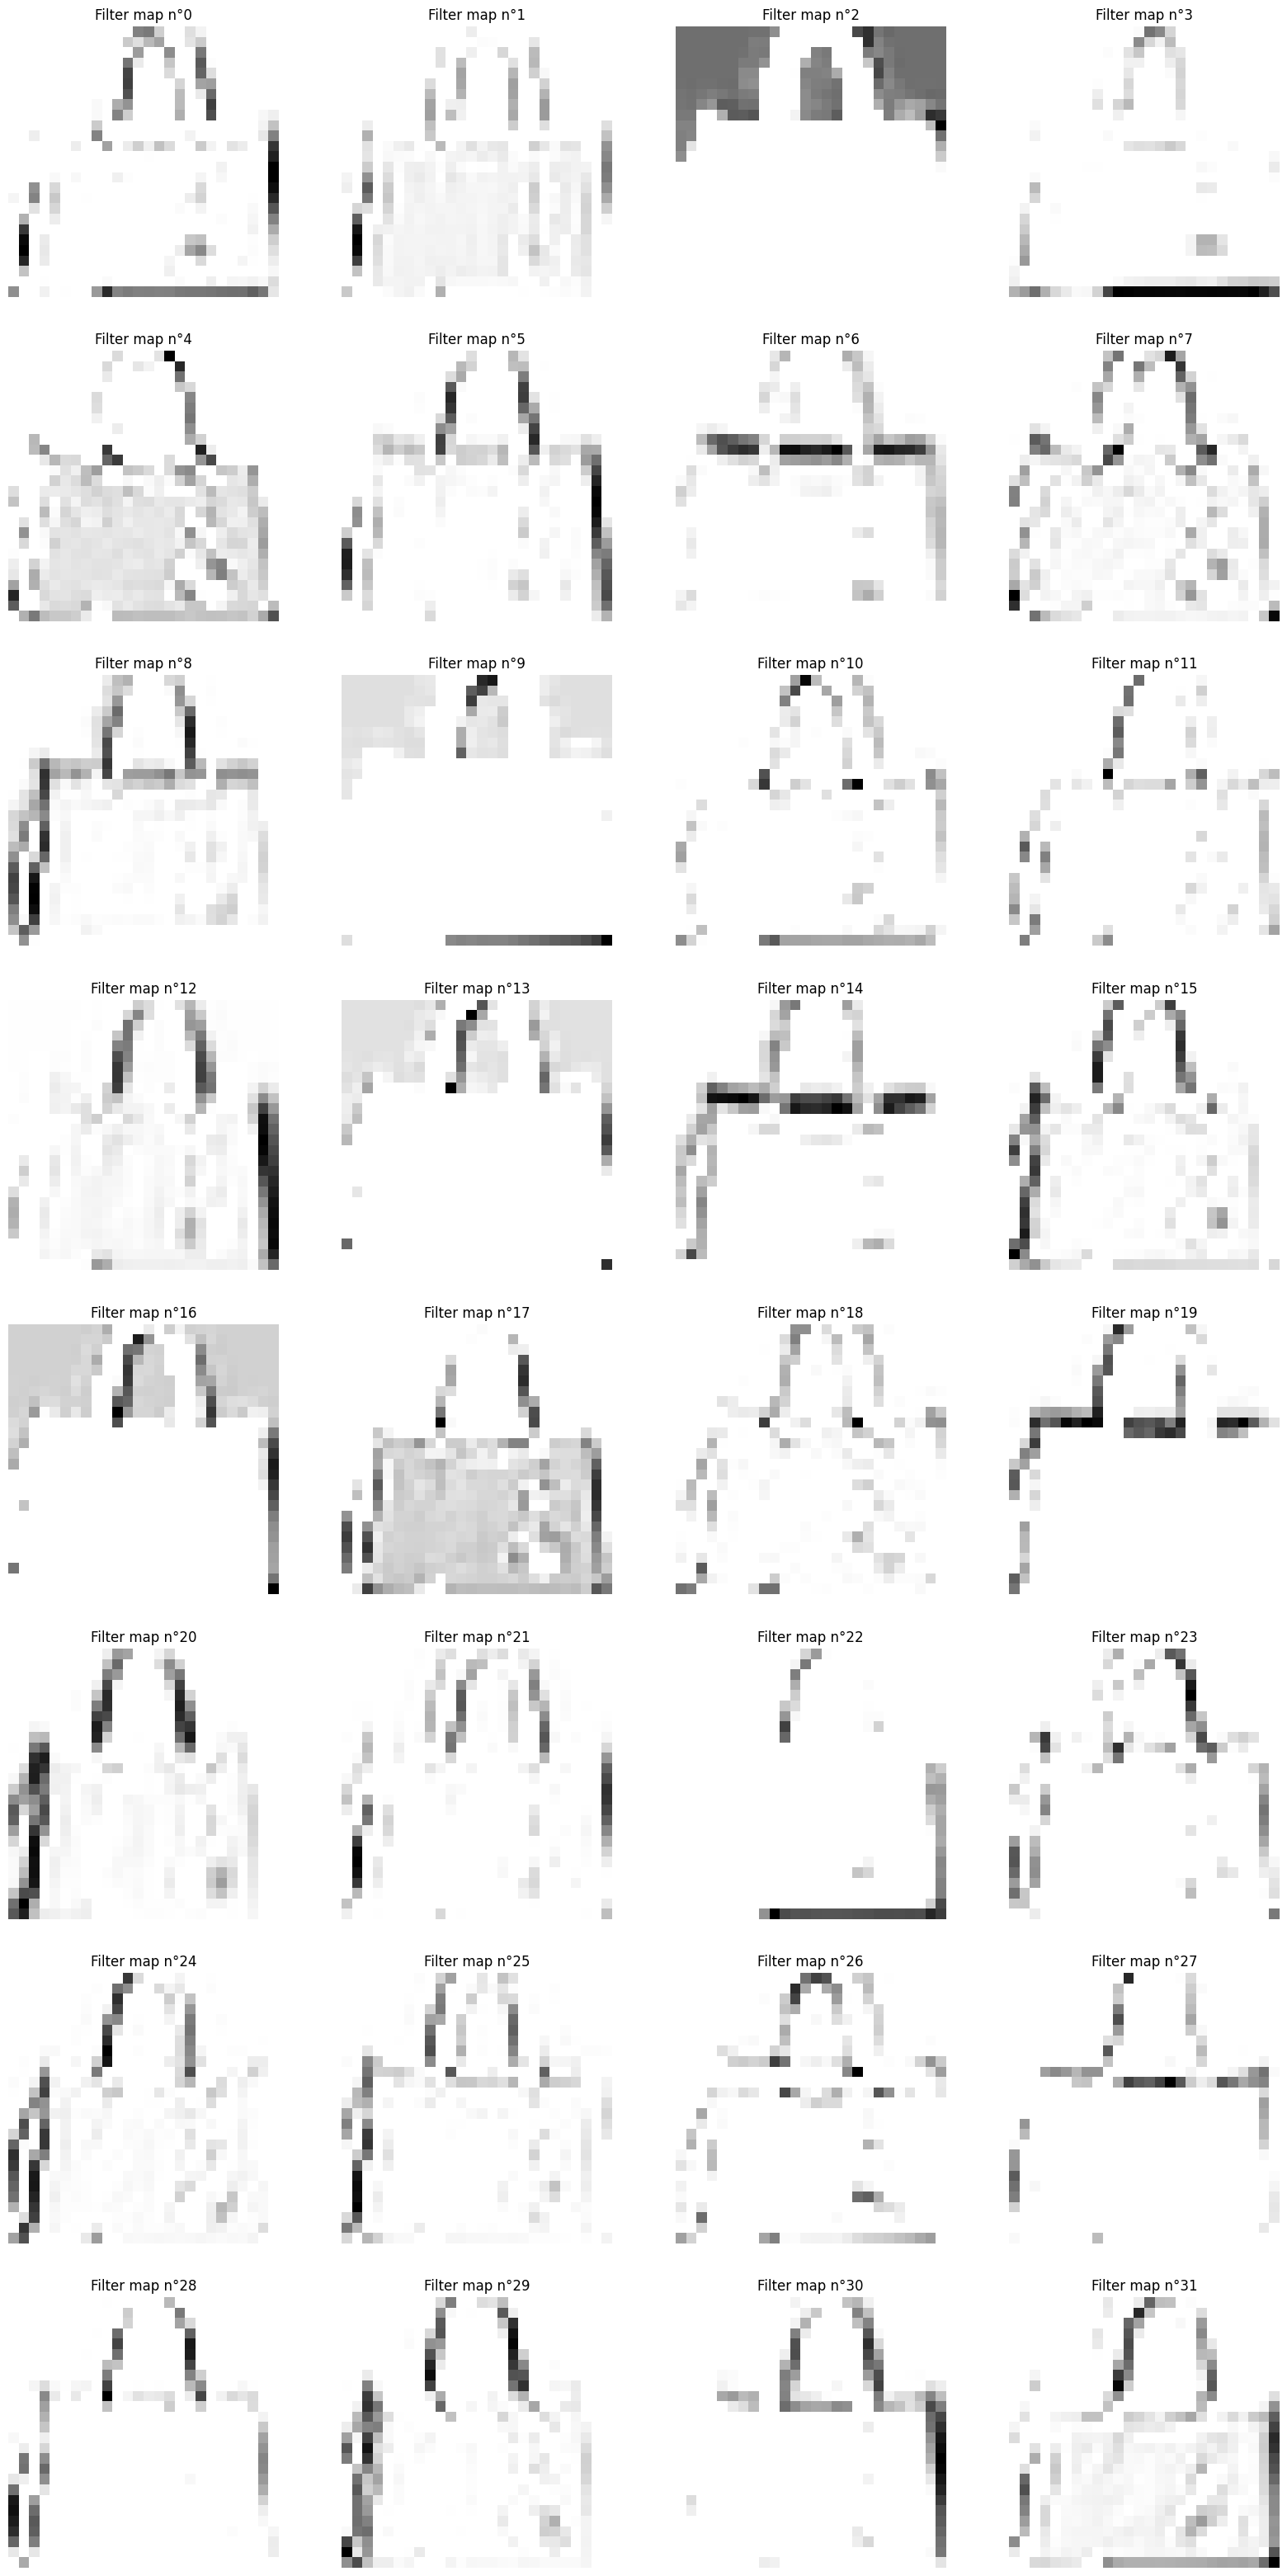

In [ ]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 40))
for i, ax in enumerate(axes.flat):
    ax.imshow(activations[0, :, :, i], cmap='binary')
    ax.set_title(f"Filter map n°{i}")
    ax.axis('off')
plt.show()

# Snapchat Review classification

The **Snapchat-Google-PlayStore-Reviews dataset** on OpenML is a collection of reviews for the Snapchat mobile application, which were scraped from the Google Play Store. The dataset includes more than 30,000 reviews, which have been labeled with their corresponding star ratings (1-5 stars).

Each review in the dataset includes the text of the review, the star rating given by the user, the date on which the review was posted, and the helpfulness of the review. The dataset can be used for sentiment analysis and other natural language processing tasks, as well as for studying trends and patterns in user reviews of the Snapchat application.

In this exercise, the Rating column have been modified:

*   1-star and 2-star reviews were set to a new class : "Negative"
*   3-star reviews were discarded
*   4-star and 5-star reviews were set to a new class : "Positive"

**<font color='blue'>1. Show the first reviews and their associated rating.**

In [3]:
for rating, review in snapchat_review.head().to_numpy():
    print(rating)
    print(review, end='\n\n')

Positive
Very Best camera and chat app

Positive
I love love love this app its its amazingly easy to chat with your friends and it had really funny stuff so y'all should download this app

Negative
Broken joke of an app. Nothing else to it

Positive
One of the best texting a call apps out there

Negative
Have to download it again and again so that the profiles get loaded.. there's a bug...not quite sure why is it happening!?



Count vectorizer is a popular technique in natural language processing (NLP) that is used to convert a collection of text documents into a vector.

It works by creating a vocabulary of unique words that appear in the documents and then counting the frequency of occurrence of each word in each document. **The resulting matrix is known as a document-term matrix, where each row represents a document and each column represents a word in the vocabulary**.

It can be used to **extract features from the text data**.

An implementation of the count vectorizer method can be found on **`sklearn`**.

---

The most important parameters of this implementation are:
* **`max_features`**: This parameter controls the maximum number of features (words) that are extracted from the text data. By default, all features are kept, but setting a maximum value can help reduce the dimensionality of the feature space and improve model performance.

* **`stop_words`**: This parameter allows you to specify a list of stop words to be removed from the text data before counting the occurrence of words. Stop words are common words like "the", "and", "in", etc., that are not considered informative for the task at hand.

* **`ngram_range`**: This parameter specifies the range of n-grams to be extracted from the text data. An n-gram is a contiguous sequence of n words from a text. The default is unigrams (n=1), but you can also include bigrams (n=2) or trigrams (n=3).

---

```
cv = CountVectorizer(stop_words=..., 
                     ngram_range=..., 
                     max_features=...)
vectors = cv.fit_transform(...)
```

You can find the CountVectorizer class [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer).

**<font color='blue'>2.a. Get the counts of the 50 most frequent words in the reviews excluding the stop words of the english language (*i.e. using `stop_words='english'`*).**

*Tips : CountVectorizer returns a sparse matrix object: you can convert it into an array to `.toarray()` on the output.*

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words="english",
                     max_features=50)
cm = cv.fit_transform(snapchat_review['Review_Text']).toarray()

**<font color='blue'>2.b. Display the bar plot of the 50 most frequent words.**

*Tips: You can get the words by using the `.get_feature_names_out()` method on the CountVectorizer object.*

In [5]:
count = sorted(cm.sum(axis=0))
words = cv.get_feature_names_out()[np.argsort(cm.sum(axis=0))]

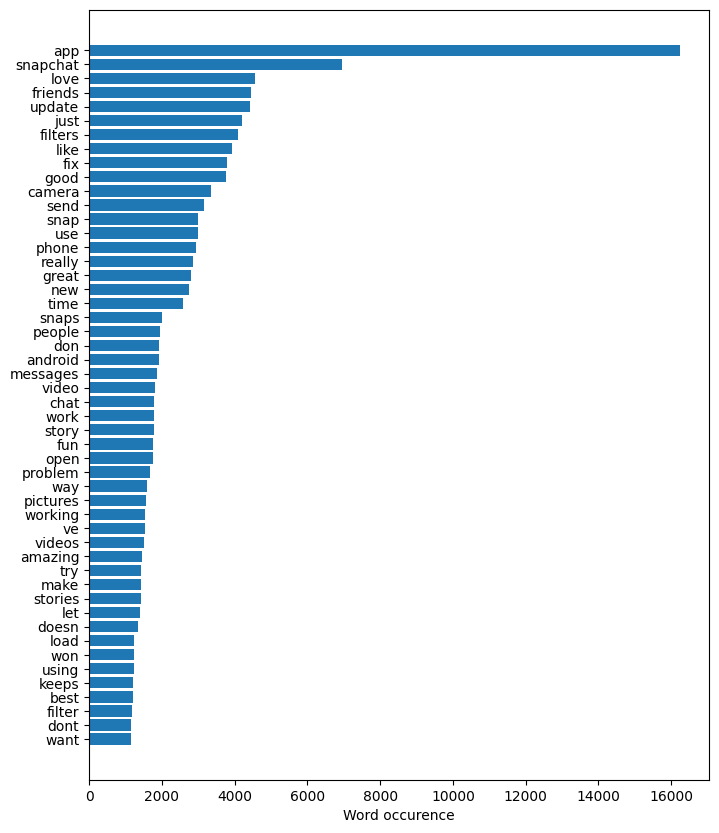

In [6]:
plt.figure(figsize=(8,10))

plt.barh(y=words,
         width=count)

plt.xlabel("Word occurence")

plt.show()

A **Wordcloud** is a visual representation of a collection of words, where the size of each word is proportional to its frequency or importance in the text. They are commonly used in text analysis, data visualization, and marketing research. 

It works by taking a text document or a collection of documents, counting the frequency of each word in the text, and then representing the most frequent words with larger fonts and the less frequent words with smaller fonts. This creates a visual image of the text that can help identify the most important or relevant words in the document or collection of documents.

Wordclouds can be built using the `wordcloud` python library. 

---

Some of the most important parameters are:

* **`max_words`**: This parameter specifies the maximum number of words that will be shown in the WordCloud image. The default value is 200.

* **`stopwords`**: This parameter allows you to pass in a set of words that will be excluded from the WordCloud. The default value is None, which means that no stopwords will be removed.
 You can get the stopwords using the `STOPWORDS` set from the wordcloud library.

Most of the parameters are modifying the look of the wordcloud such as:

* **`width`**: This parameter specifies the width of the WordCloud image in pixels. The default value is 400.

* **`height`**: This parameter specifies the height of the WordCloud image in pixels. The default value is 200.

* **`background_color`**: This parameter specifies the background color of the WordCloud image. The default value is 'black'.

---


You can use the `.generate()` method to create the wordcloud using the `WordCloud` function of the wordcloud library:
```
wc = WordCloud(...).generate(text)
```

And then use the `.imshow()` function to display the wordcloud:
```
plt.imshow(wc)
```

You can find the wordcloud library [here](https://github.com/amueller/word_cloud/blob/master/examples/simple.py).

**<font color='blue'>3.a. Merge all the reviews into a single text.**

*Tips: You can use the `str.join(iterable)` function with a space as the str.*

In [7]:
full_text = " ".join(snapchat_review['Review_Text'])

**<font color='blue'>3.b. Display a wordcloud representation of the most frequent words thanks to the wordcloud library.**

*Tips: Don't forget to use a stop words list !*

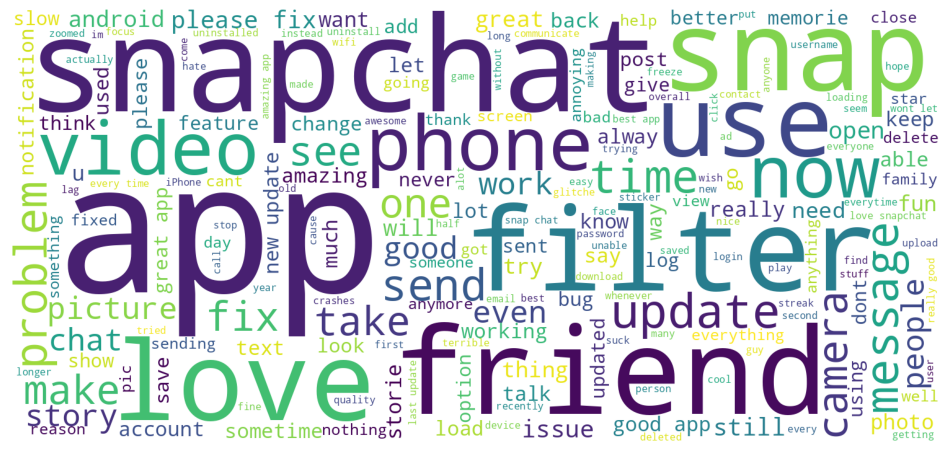

In [8]:
from wordcloud import WordCloud, STOPWORDS

wc = WordCloud(max_words=200,
               stopwords=STOPWORDS,
               width=1500, 
               height=700, 
               background_color='white',
               random_state=42).generate(full_text)

plt.figure(figsize=(12,12))
plt.imshow(wc)

plt.axis('off')
plt.show()

**Tokenization** is a crucial step in natural language processing (NLP) projects, where we want to analyze and understand human language using computer algorithms. It is the **process of breaking down a large piece of text, such as a paragraph or a sentence, into smaller units called tokens**.

Tokens are typically words, but they can also be punctuation marks, numbers, or other types of elements that we want to process separately. The reason we tokenize text is that it allows us to analyze it more efficiently and accurately, as we can focus on individual units of meaning rather than trying to understand the entire text at once.

Suppose we have the following sentence:

"The quick brown fox jumps over the lazy dog."

To tokenize this sentence, we would break it down into individual words, as follows:

`["The", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog", "."]`

Notice that we also included the period at the end of the sentence as a separate token, as it serves as a delimiter between sentences.

There are different ways to perform tokenization, depending on the specific needs of the NLP project. For instance, we may want to ignore certain types of words, such as stop words (common words like "the", "a", and "an" that don't carry much meaning), or we may want to handle special characters or symbols differently.

---

**Vectorization** is the process of converting text into a vector of numbers that represent the meaning or features of the text. Each word or token in the text is assigned a unique number or index, and the resulting vector represents the frequency or occurrence of each word or token in the text. **It generally follows the Tokenization process**.

Suppose we have the following sentence:

Sentence 1: "the quick brown fox jumps over the lazy dog."<br>
Sentence 2: "the lazy dog sleeps in the grass."

To vectorize these sentences, we first need to create a vocabulary of all the unique words or tokens in both sentences:

`["the", "quick", "brown", "fox", "jumps", "over", "lazy", "dog", ".", "sleeps", "in", "grass"]`

Next, we assign each word or token in the vocabulary a unique index, starting from 0:

`{"the":0, "quick":1, "brown":2, "fox":3, "jumps":4, "over":5, "lazy":6, "dog":7, ".":8, "sleeps":9, "in":10, "grass":11}`

Finally, we represent each sentence as a vector of numbers:<br>
Sentence 1: `[1,2,3,4,5,6,7,8]`<br>
Sentence 2: `[1,6,7,9,10,0,11,8]`

**<font color='blue'>4.a. Count the number of words for each review and display an histogram.**

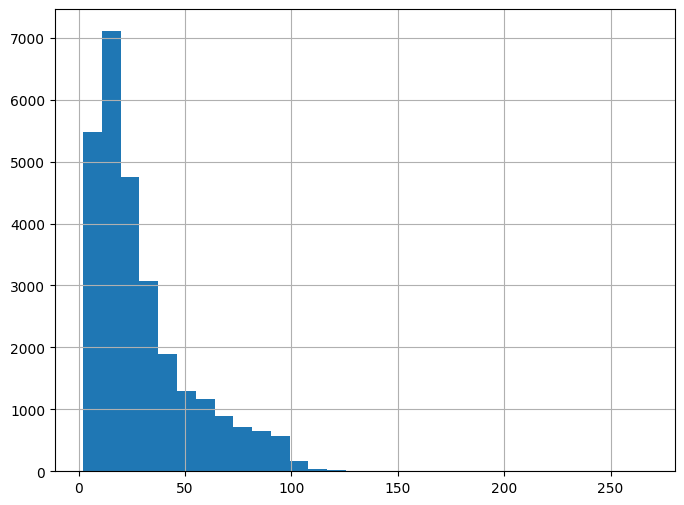

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
snapchat_review['Review_Text'].transform(lambda x:len(x.split())).hist(bins=30, ax=ax)
plt.show()

The **`TextVectorization`** layer from Keras automatically handles both tokenization and vectorization of text data.

Here are some of the most important parameters of the TextVectorization layer:

* **`max_tokens`**: This parameter specifies the maximum number of tokens (words or sub-words) to be used in the vocabulary. In other words, it controls the maximum number of unique words or sub-words that will be used to represent the input text data.

* **`output_mode`**: This parameter determines the output format of the layer. It can be set to "int" to output integer-encoded vectors, "binary" to output binary-encoded vectors, or "tf-idf" to output term frequency-inverse document frequency vectors.

* **`output_sequence_length`**: This parameter specifies the maximum length of the output sequences. If the sequences are shorter than this length, they will be padded with zeros, and if they are longer, they will be truncated.

```
vect = tf.keras.layers.TextVectorization(max_tokens=...,
                                         output_mode=...,
                                         output_sequence_length=...)
vect.adapt(snapchat_review['Review_Text'].to_numpy())
```

**<font color='blue'>4.b. Create the `TextVectorization` function with a 5000 words limit that will returns integers for every word (`output_mode = 'int'`).<br>Set the sequence length limit according to the histogram of the previous question.<br>Initialize its vocabulary using the `.adapt()` method on the reviews.**

*Tips: The TextVectorization layer doesn't accept Pandas DataFrame/Series. You will need to convert it to another format such as a numpy array.*

In [11]:
vect = tf.keras.layers.TextVectorization(max_tokens=5000,
                                         output_mode='int',
                                         output_sequence_length=125)
vect.adapt(snapchat_review['Review_Text'].to_numpy())

In [12]:
# The [UNK] token is a special token used in natural language processing
# that represents an unknown or out-of-vocabulary (OOV) word. 

print(f"There are : {len(vect.get_vocabulary())} words in the vocabulary")
print(f"The first 10 words are : {vect.get_vocabulary()[:10]}")
print(f"The last 10 words are : {vect.get_vocabulary()[-10:]}")

There are : 5000 words in the vocabulary
The first 10 words are : ['', '[UNK]', 'i', 'the', 'it', 'and', 'to', 'app', 'a', 'my']
The last 10 words are : ['excitement', 'exchange', 'excessive', 'exceptionally', 'exception', 'exaggerating', 'evrything', 'evry', 'evn', 'eveything']


**<font color='blue'>4.c. Transform the reviews using the TextVectorization function and encode the label into numbers.**

In [13]:
X = vect(snapchat_review['Review_Text'].to_numpy()).numpy()

# This review is less than 125 words, thus the end is padded with 0's
X[0]

array([ 54, 121,  40,   5,  85,   7,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0])

In [14]:
from sklearn.preprocessing import LabelEncoder

y = snapchat_review['Rating'].to_numpy()
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y)

**<font color='blue'>5. Create a training, a validation and a testing set.**

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,
                                                  test_size=0.2/(1-0.2), 
                                                  stratify=y_train, 
                                                  random_state=42)

The shape of the input data in a recurrent neural network is typically `[batch, timesteps, feature]`:

* **`batch`**: The batch dimension represents the number of samples that are processed at once. In NLP tasks, this is often a batch of sentences or documents that are being processed together. The batch dimension allows the RNN to process multiple input sequences in parallel, which can speed up training and improve model accuracy.

* **`timesteps`**: The timesteps dimension represents the number of time steps in each input sequence. In the context of NLP, this corresponds to the number of words or tokens in each sentence or document. By processing the input data one timestep at a time, the RNN can build up a representation of the input sequence that captures its temporal dynamics.

* **`feature`**: The feature dimension represents the number of features in each timestep. In NLP tasks, this typically corresponds to the number of words in a vocabulary or the size of the word embeddings being used. The feature dimension allows the RNN to represent each word or token as a vector of numerical features, which can then be processed by the network.

**<font color='blue'>6. Change the shape of the tokenized & vectorized reviews from (instances, sequence) to (instances, sequence length, 1).**

*Tips: You can use `arr[...,np.newaxis]` to add an extra dimension if you're using Numpy arrays.*

In [16]:
X_train = X_train[...,np.newaxis]
X_val = X_val[...,np.newaxis]
X_test = X_test[...,np.newaxis]

An **embedding** is a way of representing words or phrases as numerical vectors that capture their meaning or context in a way that can be processed by a computer algorithm. Essentially, **embeddings are a way of mapping words or phrases to points in a high-dimensional space**.

<center><img width=50% src=https://www.tensorflow.org/static/text/guide/images/embedding2.png></center>

<center><i>Here, each word is transformed into a vector of size 4.</i></center>

The idea behind embeddings is that **words and phrases that are used in similar contexts or have similar meanings should be represented by similar vectors in the embedding space**. For instance, the words "car" and "vehicle" are often used in similar contexts and have similar meanings, so they should be represented by vectors that are close together in the embedding space.

<center><img src=https://thethoughtprocess.xyz/wp-content/uploads/2020/06/1_jnrmjaYMF_gq-9zia2HV7g-1-1.png></center>

<center><i>The words can now be represented in N-dimensional space.<br> We can visualize them in a 2D or 3D space using dimensionality reduction techniques.</i></center>

To create embeddings, we typically start with a large corpus of text data and train a neural network to predict the context of each word in the corpus based on the context of the surrounding words. During training, the neural network adjusts the embedding vectors to minimize the prediction error, resulting in vectors that capture the semantic and contextual relationships between words.

---

**`Tensorflow`** provides an Embedding layer that can be used inside a neural network like another regular layer of neurons.

Here are some of its most important parameters:

* **`input_dim`**: This parameter specifies the size of the vocabulary or the maximum integer index that can be used as an input to the Embedding layer. For instance, if the largest integer index in the input data is 100, then input_dim should be set to 101 (since integer indices start at 0).

* **`output_dim`**: This parameter specifies the size of the dense embedding vectors that will be learned by the Embedding layer. A larger output_dim value will result in more expressive embeddings, but also requires more computational resources.

* **`mask_zero`**: This parameter specifies whether or not to treat the integer value 0 as a special "padding" value that should be masked out of the input sequences. If set to True, the Embedding layer will ignore 0 values in the input sequences and will not update the corresponding embedding vectors.

---

```
tf.keras.layers.Embedding(input_dim=..., 
                          output_dim=..., 
                          mask_zero=...)
```

You can find the Embedding layer [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding).

**<font color='blue'>7.a. Create an embedding layer with the input dimension equal to size of the chosen vocabulary and the output dimension equal to 20.<br> Set `mask_zero=True`.**

In [17]:
embedding = tf.keras.layers.Embedding(5000, 20, mask_zero=True)

A **Recurrent Neural Network** (RNN) is a type of neural network that models sequences of input data, such as sentences or documents. The main idea behind RNNs is to use feedback connections to allow the network to "remember" previous inputs and use that information to inform its current output.

<center><img width=70% height=auto src=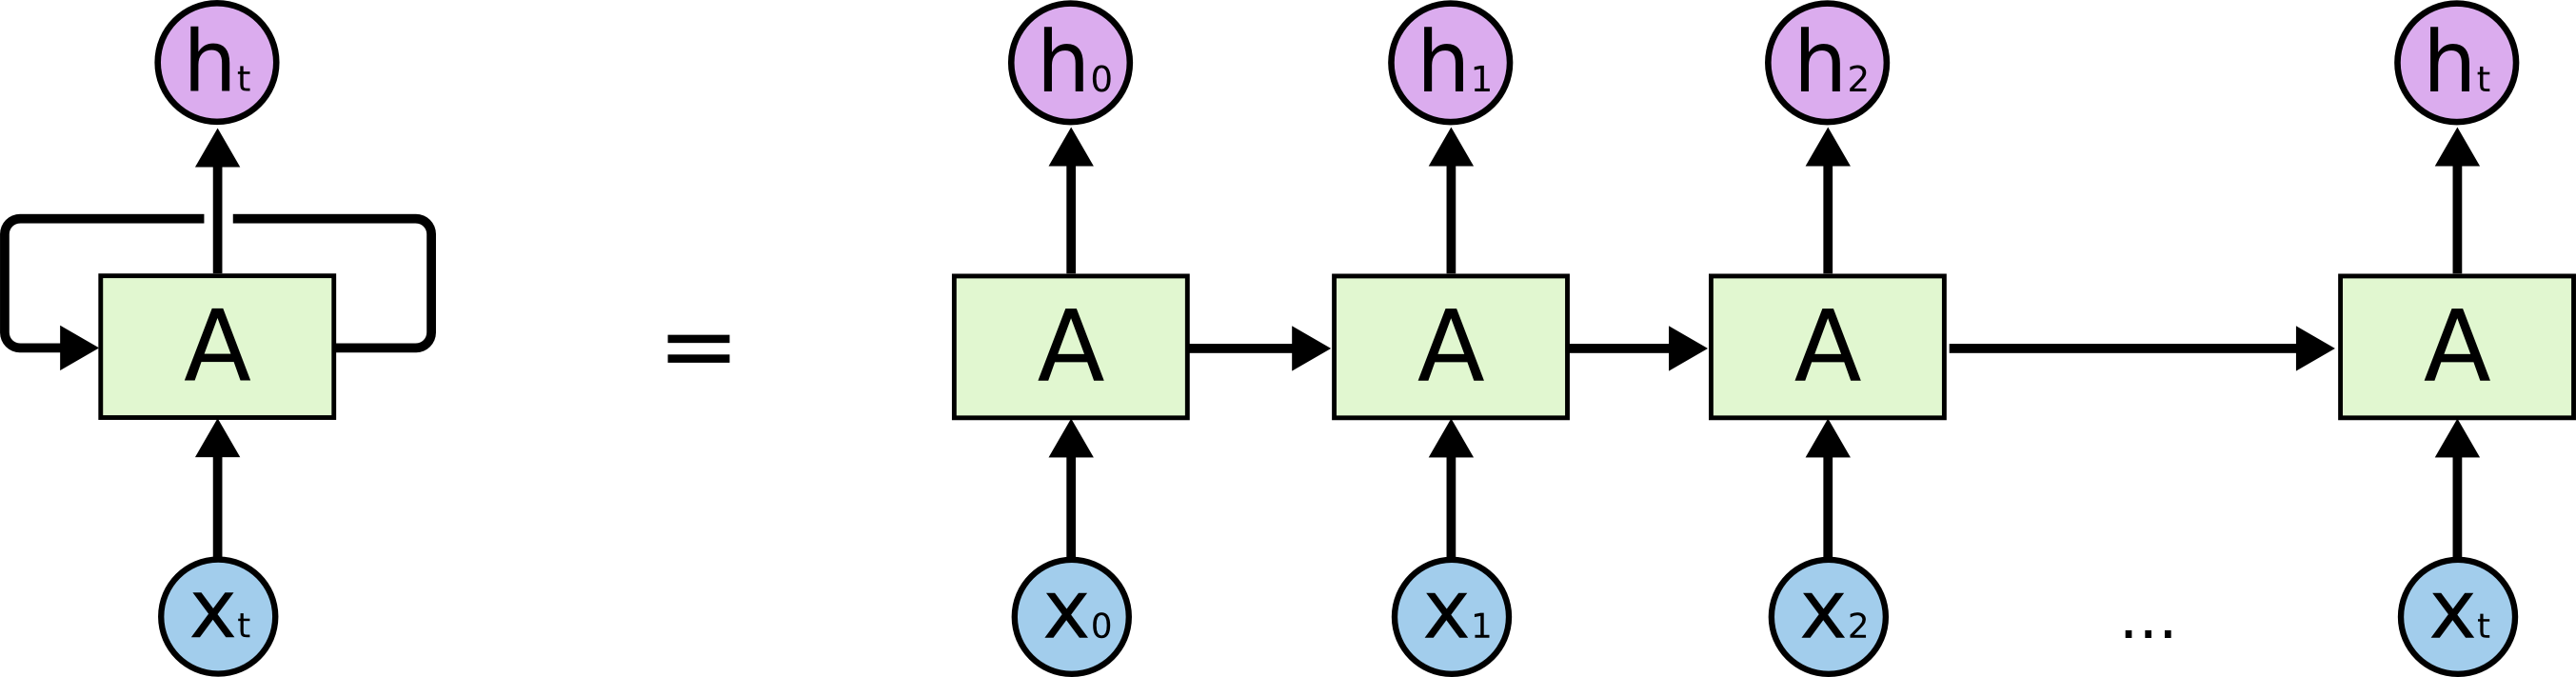></center>

<center><i>Each recurrent neuron can read a sequence element by element while keeping track of the previous elements (i.e. memory).</i></center>

**Long Short-Term Memory or LSTM** is another type of recurrent neural network that is commonly used in natural language processing tasks. The basic idea behind LSTMs is to introduce a memory cell that can store information over long periods of time and selectively update that memory based on the input data. **LSTMs are better able to handle long-term dependencies in the input data**.

---

Tensorflow provides an LSTM layer implementation.

Here are some of the most important parameters:

* **`units`**: This parameter specifies the dimensionality of the output space of the LSTM layer. Essentially, it determines the size of the memory cell and the hidden state vector of the LSTM. Larger values of units can capture more complex relationships in the input data, but may also require more computational resources.

* **`return_sequences`**: This parameter specifies whether to return the full sequence of outputs from the LSTM layer or just the final output. If set to True, the LSTM layer will return a sequence of outputs for each timestep in the input sequence. If set to False, the LSTM layer will only return the output for the final timestep. It should be set to True  when the LSTM layer is followed by another recurrent layer (LSTM, RNN ...).

The `activation` parameter that controls the activation function should generally not be modified in an LSTM.

---


```
tf.keras.layers.LSTM(units=...,
                     activation=...,
                     return_sequences=...)
```

You can find the LSTM documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM).

**<font color='blue'>7.b. Create a model using:**

*   **<font color='blue'>One embedding layer**
*   **Followed by one LSTM layer with 32 units**
*   **Followed by a final dense layer for a classification task.****

In [18]:
tf.keras.backend.clear_session()

model_lstm = tf.keras.models.Sequential([tf.keras.Input(shape=(125,)),
                                         embedding,
                                         tf.keras.layers.LSTM(32),
                                         tf.keras.layers.Dense(1, activation='sigmoid')])

**<font color='blue'>7.c. Show its architecture.**

In [19]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 125, 20)           100000    
                                                                 
 lstm (LSTM)                 (None, 32)                6784      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 106,817
Trainable params: 106,817
Non-trainable params: 0
_________________________________________________________________


**<font color='blue'>8.a. Compile the model using the Adam optimizer with a learning rate of 0.0001 and the correct loss for this task.**

In [20]:
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=['accuracy'])

**<font color='blue'>8.b. Tain the model for 10 epochs with a batch size of 32.**

*Tips: Don't forget the validation data.*

In [21]:
history = model_lstm.fit(X_train, y_train, 
                         epochs=10,
                         batch_size=32,
                         validation_data=(X_val, y_val))

Epoch 1/10
523/523 [==============================] - 54s 82ms/step - loss: 0.6194 - accuracy: 0.6758 - val_loss: 0.5002 - val_accuracy: 0.8445
Epoch 2/10
523/523 [==============================] - 12s 24ms/step - loss: 0.4637 - accuracy: 0.8535 - val_loss: 0.4486 - val_accuracy: 0.8538
Epoch 3/10
523/523 [==============================] - 9s 18ms/step - loss: 0.4229 - accuracy: 0.8621 - val_loss: 0.4254 - val_accuracy: 0.8535
Epoch 4/10
523/523 [==============================] - 11s 20ms/step - loss: 0.3943 - accuracy: 0.8685 - val_loss: 0.4109 - val_accuracy: 0.8567
Epoch 5/10
523/523 [==============================] - 9s 18ms/step - loss: 0.3664 - accuracy: 0.8760 - val_loss: 0.3907 - val_accuracy: 0.8587
Epoch 6/10
523/523 [==============================] - 7s 14ms/step - loss: 0.3460 - accuracy: 0.8825 - val_loss: 0.3813 - val_accuracy: 0.8578
Epoch 7/10
523/523 [==============================] - 10s 20ms/step - loss: 0.3327 - accuracy: 0.8855 - val_loss: 0.3738 - val_accuracy: 0.

**<font color='blue'>8.c. Display the learning curves.**

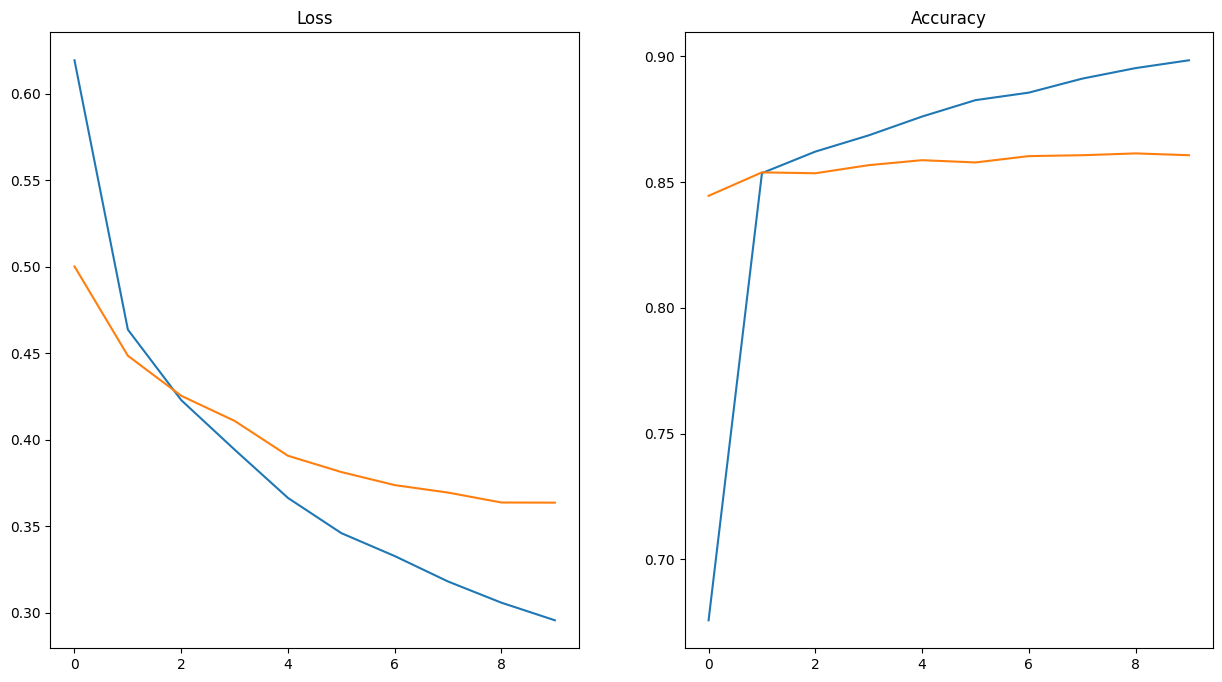

In [22]:
fig, axs = plt.subplots(1,2,figsize=(15,8))

axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='val loss')
axs[0].set_title('Loss')
axs[1].plot(history.history['accuracy'], label='accuracy')
axs[1].plot(history.history['val_accuracy'], label='val accuracy')
axs[1].set_title('Accuracy')

plt.show()

You can visualize the embedding using the Tensorflow Projector [website](https://projector.tensorflow.org/).

**<font color='blue'>(To do with the professor) Display the embedding.**

In [23]:
# Get the embedding from the model
embedding = model_lstm.layers[0]

# Remove the first two words : the padding character "" and the unknown character [UNK]
embedding_weights = embedding.get_weights()[0][2:]

# Save into .tsv format using the '\t' delimiter
np.savetxt('embeddings.tsv', embedding_weights, delimiter='\t')

In [24]:
# The first word ("the") embedding
with open("embeddings.tsv", 'r') as f:
    lines = f.readlines()
lines[0]

'-5.794035270810127258e-03\t-4.331022128462791443e-02\t-6.758433301001787186e-03\t-4.094316065311431885e-02\t3.115508519113063812e-02\t1.617302559316158295e-02\t-2.156417444348335266e-02\t5.100013315677642822e-02\t-4.459287971258163452e-02\t-4.450701642781496048e-03\t3.389045596122741699e-02\t4.753311350941658020e-02\t3.142727166414260864e-02\t-4.505573958158493042e-02\t-7.252601440995931625e-03\t3.845040872693061829e-02\t-3.873804584145545959e-02\t-1.938583515584468842e-02\t-2.972034737467765808e-02\t4.151817038655281067e-02\n'

In [25]:
# Get the vocabulary from the TextVectorization layer
# ... and remove the first two words : "" and [UNK]
vocabulary = vect.get_vocabulary()[2:]

# Create a list of words and their associated token
metadata = [f"{word}\t{i+2}" for i, word in enumerate(vocabulary)]

# Save the metadata into a .tsv file using the '\t' delimiter
with open("metadata.tsv", "w") as metadata_file:
    metadata_file.write("Word\tToken\n") # Add a title to the columns
    metadata_file.write("\n".join(metadata))

In [26]:
# The resulting metadata
with open("metadata.tsv", 'r') as f:
    lines = f.readlines()
lines[:10]

['Word\tToken\n',
 'i\t2\n',
 'the\t3\n',
 'it\t4\n',
 'and\t5\n',
 'to\t6\n',
 'app\t7\n',
 'a\t8\n',
 'my\t9\n',
 'is\t10\n']